In [1]:
%load_ext autoreload
%autoreload 2a

import importlib
import io
import os
import sys
import csv
import gzip
import time
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

importlib.reload(lcwgsus)

/gpfs3/well/band/users/rbx225/GAMCC


<module 'lcwgsus' from '/well/band/users/rbx225/software/lcwgsus/lcwgsus/__init__.py'>

# Currently working on: IMPUTATION 

In [2]:
mini = False
lc_sample_prefix = 'GM'
chip_sample_prefix = 'GAM'
seq_sample_prefix = 'IDT'
by_variant = True # True if average each row, False if average each column (sample)
    
MAF_ary = np.array([0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.95, 1])
sample_linker = pd.read_table('data/metadata/sample_linker.csv', sep = ',')
chromosome = 22
common_cols = ['chr', 'pos', 'ref', 'alt']

if not mini:
    sample_linker = sample_linker[~sample_linker['Sample_Name'].str.contains('mini')]
else:
    sample_linker = sample_linker[sample_linker['Sample_Name'].str.contains('mini')]
rename_map = dict(zip(sample_linker['Sample_Name'], sample_linker['Chip_Name']))

quilt_vcf = "/well/band/users/rbx225/GAMCC/results/imputation/vcfs/oneKG/quilt.chr" + str(chromosome) + ".vcf.gz"
chip_vcf = "/well/band/users/rbx225/GAMCC/results/chip/vcf/chip_by_chr/chip.chr" + str(chromosome) + ".vcf.gz"
lc = lcwgsus.read_vcf(quilt_vcf).sort_values(by = ['chr', 'pos'])
chip = lcwgsus.read_vcf(chip_vcf).sort_values(by = ['chr', 'pos'])

if not mini:
    lc = lc.drop(columns = lc.columns[lc.columns.str.contains('mini')])
else:
    lc = lc.drop(columns = lc.columns[~lc.columns.str.contains('mini')])

af = "data/gnomAD_MAFs/afr/gnomAD_MAF_afr_chr" + str(chromosome) + ".txt"
af = lcwgsus.read_af(af)

lc = lc.drop(columns = ['ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'])
chip = chip.drop(columns = ['ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'])

res = lcwgsus.intersect_dfs([chip, lc, af])
chip = res[0]
lc = res[1]
af = res[2]

lc_samples = lc.columns[lc.columns.str.contains(lc_sample_prefix)]
chip_samples = chip.columns[chip.columns.str.contains(chip_sample_prefix)]
lc_to_retain = lcwgsus.find_matching_samples(lc_samples, chip_samples, rename_map)
quilt_columns = list(lc.columns[~lc.columns.str.contains(lc_sample_prefix)]) + lc_to_retain
lc = lc[quilt_columns]

lc = lc.apply(lcwgsus.extract_DS, axis = 1)
chip = chip.apply(lcwgsus.encode_genotype, axis = 1)

chip_order = []
for i in lc_to_retain:
    chip_order.append(rename_map[i])
chip = chip[common_cols + chip_order]

In [6]:
h_report = lcwgsus.calculate_h_imputation_accuracy(chip, lc, af, 
                                                   save_file = False, 
                                                   outdir = 'results/imputation_metrics/lc_chip/by_variant/', 
                                                   save_name = 'lc.chip.typed.chr' + str(chromosome) +'.h.tsv')

h_report = h_report.drop(columns = common_cols)

h_impacc = lcwgsus.generate_h_impacc(h_report, 
                                   save_impacc = False, 
                                   outdir = 'results/imputation_metrics/lc_chip/by_variant/', 
                                   save_name = 'lc.chip.typed.chr' + str(chromosome) +'.h.impacc.tsv')
h_impacc

,AF,n_variants,NRC,NRC_BC,NRC_AC,r2,r2_BC,r2_AC,ccd_homref,ccd_homref_BC,ccd_homref_AC,ccd_het,ccd_het_BC,ccd_het_AC,ccd_homalt,ccd_homalt_BC,ccd_homalt_AC
0,0.0000,0,-9.000000,0,0,-9.000000,0,0,-9.000000,0,0,-9.000000,0,0,-9.000000,0,0
1,0.0001,335,0.500000,2,2,0.804727,2,371,0.999887,335,62168,0.500000,2,2,-9.000000,0,0
2,0.0002,126,0.000000,2,2,0.000067,1,186,1.000000,126,23374,0.000000,2,2,-9.000000,0,0
3,0.0005,217,0.000000,3,3,0.000124,3,556,0.999925,217,40264,0.000000,3,3,-9.000000,0,0
4,0.0010,151,0.400000,2,5,0.646664,1,186,0.999822,151,28014,0.400000,2,5,-9.000000,0,0
5,0.0020,231,0.653846,12,26,0.642744,12,2225,0.999837,231,42830,0.653846,12,26,-9.000000,0,0
6,0.0050,548,0.877637,106,237,0.862088,106,19641,0.999684,548,101371,0.876068,106,234,1.000000,3,3
7,0.0100,721,0.855947,406,1673,0.930937,406,75257,0.999500,721,132014,0.945406,406,1502,0.070175,14,171
8,0.0200,1451,0.956734,1252,7581,0.937372,1251,232071,0.999117,1451,261559,0.959321,1252,7424,0.834395,129,157
9,0.0500,2336,0.967675,2265,28770,0.952570,2265,419940,0.998843,2336,404336,0.970292,2265,27871,0.886541,631,899


In [3]:
v_report = lcwgsus.calculate_v_imputation_accuracy(chip, lc, af, 
                                                   save_file = True, 
                                                   outdir = 'results/imputation_metrics/lc_chip/by_sample/', 
                                                   save_name = 'lc.chip.typed.chr' + str(chromosome) +'.v.tsv')

v_impacc = lcwgsus.generate_v_impacc(v_report, 
                                   save_impacc = True, 
                                   outdir = 'results/imputation_metrics/lc_chip/by_sample/', 
                                   save_name = 'lc.chip.typed.chr' + str(chromosome) +'.v.impacc.tsv')
# Ignore the _BC fields in vertical reports as they are not reliable
v_impacc

,AF,n_variants,NRC,NRC_BC,NRC_AC,r2,r2_BC,r2_AC,ccd_homref,ccd_homref_BC,ccd_homref_AC,ccd_het,ccd_het_BC,ccd_het_AC,ccd_homalt,ccd_homalt_BC,ccd_homalt_AC
0,0.0000,0,-9.000000,0.000000,0,-9.000000,0.000000,0,-9.000000,0.000000,0,-9.000000,0.000000,0,-9.000000,0.000000,0
1,0.0001,335,0.500000,1.000000,2,0.738208,334.500000,669,0.999887,334.236559,62168,0.500000,1.000000,2,-9.000000,0.000000,0
2,0.0002,126,0.000000,1.000000,2,0.000129,126.000000,252,1.000000,125.666667,23374,0.000000,1.000000,2,-9.000000,0.000000,0
3,0.0005,217,0.000000,1.000000,3,0.000079,217.000000,651,0.999925,216.473118,40264,0.000000,1.000000,3,-9.000000,0.000000,0
4,0.0010,151,0.400000,1.000000,5,0.599601,151.000000,755,0.999822,150.612903,28014,0.400000,1.000000,5,-9.000000,0.000000,0
5,0.0020,231,0.653846,1.238095,26,0.765945,230.809524,4847,0.999837,230.268817,42830,0.653846,1.238095,26,-9.000000,0.000000,0
6,0.0050,548,0.877637,1.866142,237,0.830246,546.086614,69353,0.999684,545.005376,101371,0.876068,1.857143,234,1.000000,1.000000,3
7,0.0100,721,0.855947,8.994624,1673,0.639863,718.747312,133687,0.999500,709.752688,132014,0.945406,8.118919,1502,0.070175,1.082278,171
8,0.0200,1450,0.956700,40.725806,7575,0.936947,1445.989247,268954,0.999116,1405.263441,261379,0.959288,39.881720,7418,0.834395,1.891566,157
9,0.0500,2336,0.967675,154.677419,28770,0.959316,2328.526882,433106,0.998843,2173.849462,404336,0.970292,149.844086,27871,0.886541,5.022346,899


In [126]:
chromosomes = [str(i) for i in range(1,23)]
h_lst = ["results/imputation_metrics/lc_chip/by_variant/lc.chip.typed.chr" + i + ".h.impacc.tsv" for i in chromosomes]
v_lst = ["results/imputation_metrics/lc_chip/by_sample/lc.chip.typed.chr" + i + ".v.impacc.tsv" for i in chromosomes]

h_dfs = [pd.read_csv(i, sep = '\t') for i in h_lst]
v_dfs = [pd.read_csv(i, sep = '\t') for i in v_lst]

In [123]:
def calculate_weighted_average(ary, weights):
    ary = np.array(ary)
    weights = np.array(weights)
    if ary.size == 0 or weights.size == 0 or weights.sum() == 0:
        return -9
    else:
        num = weights.sum()
        avg = (ary*weights).sum()/num
    return avg
def average_impacc_by_chr(impacc_lst, 
                          MAF_ary = np.array([0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.95, 1]),
                         colnames = ['n_variants', 'NRC', 'NRC_BC', 'NRC_AC', 
                                  'r2', 'r2_BC', 'r2_AC', 
                                  'ccd_homref', 'ccd_homref_BC', 'ccd_homref_AC', 
                                  'ccd_het', 'ccd_het_BC', 'ccd_het_AC',
                                  'ccd_homalt', 'ccd_homalt_BC', 'ccd_homalt_AC']):
    impacc = pd.DataFrame({'AF': MAF_ary})
    for i in range(MAF_ary.size):
        tmp_lst = [df[df['AF'] == MAF_ary[i]] for df in impacc_lst]
        merge_df = pd.concat(tmp_lst)
        metrics = [merge_df[colnames[0]].mean()]
        for j in range(len(colnames)):
            if j%3 == 1:
                triplet = merge_df[colnames[j:j+3]]
                triplet = triplet[triplet[colnames[j]] != -9]
                if triplet.shape[0] == 0:
                    metrics = metrics + [-9, 0, 0]
                elif triplet.shape[0] == 1:
                    metrics = metrics + list(triplet.iloc[0, :].values)
                else:
                    metrics = metrics + [calculate_weighted_average(triplet.iloc[:, 0].values, triplet.iloc[:, 2]), triplet.iloc[:, 1].mean(), triplet.iloc[:, 2].sum()]
        if i == 0:
            res_ary = metrics
        else:
            res_ary = np.vstack([res_ary, metrics])
    res_ary = res_ary.T
    for name, col in zip(colnames, res_ary):
        impacc[name] = col
    return impacc

res = average_impacc_by_chr(h_dfs)

/tmp/slurm-52625077/ipykernel_120981/1549120337.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc, label='Allele Frequency Counts')


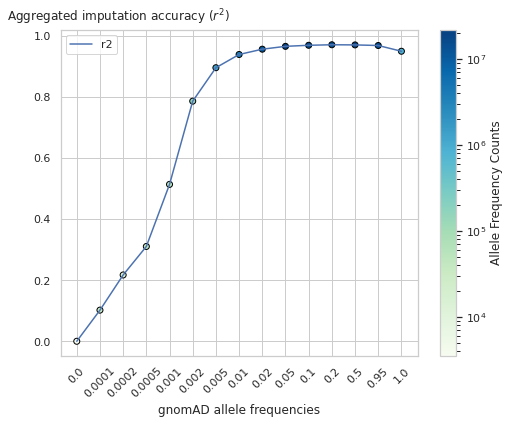

In [125]:
import matplotlib.colors as mcolors

tmp = res[['AF', 'r2', 'r2_AC']]
tmp = tmp[tmp['r2'] != -9]
def plot_imputation_accuracy(df, save_fig = False, outdir = None, save_name = None):
    plt.figure(figsize=(8, 6))
    plt.grid()
    x = np.arange(df.shape[0])
    afs = df[df.columns[0]]
    vals = df[df.columns[1]]
    color = df[df.columns[2]]
    
    plt.plot(x, vals, label = tmp.columns[1])
    plt.xticks(x, afs, rotation = 45)
    sc = plt.scatter(x, vals, c=color, cmap='GnBu', norm=mcolors.LogNorm(), edgecolor='black')
    plt.colorbar(sc, label='Allele Frequency Counts')

    plt.xlabel('gnomAD allele frequencies')
    plt.legend()
    plt.text(x = -3, y = 1.05, s = 'Aggregated imputation accuracy ($r^2$)')
    ax = plt.gca()
    ax.grid()
    if save_fig:
        plt.savefig(outdir + save_name, bbox_inches = "tight", dpi=300)
plot_imputation_accuracy(tmp)

In [5]:
cols = list(tq.columns)
minicols = [s for s in cols if "mini" in s]
mini = tq[list(tq.columns[:9]) + minicols]
fvcols = [s for s in cols if "mini" not in s]
fv = tq[fvcols]

In [7]:
rename_map = dict(zip(sample_linker['Sample_Name'], sample_linker['Chip_Name']))

for col in mini.columns:
    if col in rename_map:
        mini.rename(columns={col: rename_map[col]}, inplace=True)

for col in fv.columns:
    if col in rename_map:
        fv.rename(columns={col: rename_map[col]}, inplace=True)
fv = fv[[col for col in chip.columns]]
# mini = mini[[col for col in chip.columns]]

KeyError: "['ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'] not in index"

In [69]:
fv

,chr,pos,ID,ref,alt,QUAL,FILTER,INFO,FORMAT,GAM013489,...,GAM897412,GAM905721,GAM907384,GAM916387,GAM918732,GAM942670,GAM946580,GAM951206,GAM967203,GAM975418
438038,22,48885766,.,T,C,.,PASS,EAF=0.04055;INFO_SCORE=0.96872;HWE=0.00327;ERC...,GT:GP:DS,"0|0:0.998,0.002,0:0.002",...,"0|0:0.992,0.008,0:0.008","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002"
438039,22,48886668,.,G,A,.,PASS,EAF=0.88702;INFO_SCORE=0.94299;HWE=0.0136;ERC=...,GT:GP:DS,"1|1:0,0.002,0.998:1.998",...,"1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.002,0.998:1.998","1|1:0,0.003,0.997:1.997","0|1:0.001,0.936,0.063:1.062","1|1:0,0.002,0.998:1.998"
438040,22,48888398,.,G,A,.,PASS,EAF=0.12345;INFO_SCORE=0.95929;HWE=0.771;ERC=2...,GT:GP:DS,"0|0:0.998,0.002,0:0.002",...,"0|0:0.455,0.545,0.001:0.546","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","1|0:0.001,0.998,0.001:1","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.973,0.027,0:0.027","0|0:0.998,0.002,0:0.002"
438041,22,48889499,.,C,T,.,PASS,EAF=0.00101;INFO_SCORE=1;HWE=1;ERC=0.03053;EAC...,GT:GP:DS,"0|0:0.998,0.002,0:0.002",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002"
438042,22,48889784,.,A,C,.,PASS,EAF=0.26808;INFO_SCORE=0.86425;HWE=0.617;ERC=6...,GT:GP:DS,"0|0:0.994,0.006,0:0.006",...,"0|0:0.995,0.005,0:0.005","1|1:0,0.016,0.984:1.984","0|1:0.001,0.998,0.001:1","1|0:0.001,0.98,0.018:1.017","0|1:0.001,0.998,0.001:1","0|1:0.001,0.857,0.143:1.142","1|0:0.001,0.998,0.001:1","1|1:0,0.334,0.666:1.666","0|0:0.939,0.061,0:0.061","1|1:0,0.002,0.998:1.998"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439033,22,50749854,.,G,A,.,PASS,EAF=0.05963;INFO_SCORE=0.95706;HWE=0.181;ERC=1...,GT:GP:DS,"1|0:0.001,0.998,0.001:1",...,"0|0:0.998,0.002,0:0.002","1|0:0.001,0.998,0.001:1","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002"
439034,22,50749890,.,T,G,.,PASS,EAF=0.01554;INFO_SCORE=0.93158;HWE=1;ERC=2.035...,GT:GP:DS,"0|0:0.998,0.002,0:0.002",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002"
439035,22,50770140,.,G,T,.,PASS,EAF=0.27513;INFO_SCORE=0.97522;HWE=0.144;ERC=7...,GT:GP:DS,"0|0:0.998,0.002,0:0.002",...,"0|1:0.001,0.998,0.001:1","0|0:0.998,0.002,0:0.002","1|0:0.001,0.998,0.001:1","1|0:0.001,0.998,0.001:1","1|1:0,0.002,0.998:1.998","0|0:0.998,0.002,0:0.002","1|0:0.001,0.998,0.001:1","0|0:0.949,0.051,0:0.051","0|0:0.998,0.002,0:0.002","0|1:0.001,0.932,0.067:1.066"
439036,22,50777904,.,G,A,.,PASS,EAF=0.03906;INFO_SCORE=0.94006;HWE=1;ERC=11.02...,GT:GP:DS,"0|0:0.998,0.002,0:0.002",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002"


In [71]:
def get_genotype(row):
    for i in row.columns:
        s = row[i]
        if s == '0|0' or s == '0/0':
            row[i] = 0.
        elif s == '1|0' or s == '1/0':
            row[i] = 1.
        elif s == '0|1' or s == '0/1':
            row[i] = 1.
        elif s == '1|1' or s == '1/1':
            row[i] = 2.
        else:
            row[i] = -9
    return row

In [59]:
df2 = chip
df1 = fv

# col1 = df1.columns[-1]

for col in df2.columns:
    # Check if column name is in the first column of df2
    if 'GAM' in col:
        # Rename the column to the corresponding value in the third column of df2
        df2[col] = df2.apply(lcwgsus.get_genotype, axis = 1)
#     df2 = df2.dropna()
#     df2['genotype'] = df2['genotype'].astype(float)
#     df2 = df2.drop(columns = df2.columns[-2])
#     col2 = 'genotype'
# else:
#     col2 = df2.columns[-1]

df = pd.merge(df2, df1, on=['chr', 'pos', 'ref', 'alt'])
# df = df.fillna(0)
df = pd.merge(df, af, on=['chr', 'pos', 'ref', 'alt'], how='left')
# df = df.dropna()

# r2 = np.zeros((2, np.size(MAF_ary) - 1))
# for i in range(r2.shape[1]):
#     tmp = df[(MAF_ary[i+1] > df['MAF']) & (df['MAF'] > MAF_ary[i])]
#     if tmp.shape[0] == 0:
#         r2[0,i] = 0
#     else:
#         r2[0, i] = np.corrcoef(tmp[col1].values, tmp[col2].values)[0,1]**2
#     r2[1, i] = int(tmp.shape[0])

# r2_df = pd.DataFrame(r2.T, columns = ['Imputation Accuracy','Bin Count'], index = MAF_ary[1:])
# r2_df.index.name = 'MAF'

KeyError: 'call'

---
# For Gavin plot

In [18]:
chip_oneKG_chr11 = "/well/band/users/rbx225/GAMCC/results/chip/imputed/oneKG/vcf/chr11.all.vcf.gz"
chip_topmed_chr11 = "/well/band/users/rbx225/GAMCC/results/chip/imputed/topmed/vcf/chr11.all.vcf.gz"
chip_type_chr11 = "/well/band/users/rbx225/GAMCC/results/chip/imputed/oneKG/vcf/chr11.typed.vcf.gz"
quilt_oneKG_chr11 = "/well/band/users/rbx225/GAMCC/results/imputation/vcfs/oneKG/quilt.chr11.vcf.gz"
vcfs = [chip_oneKG_chr11, chip_topmed_chr11, quilt_oneKG_chr11, chip_type_chr11]
for i in vcfs:
    command = 'tabix ' + i
    subprocess.run(command, shell = True)

# if result.returncode == 0:
#     # Parse the output and create a Pandas DataFrame
#     columns = ['CHROM', 'POS', 'REF', 'ALT', 'QUAL']
#     data = [line.strip().split('\t') for line in result.stdout.split('\n') if line.strip()]
#     df = pd.DataFrame(data, columns=columns)
#     print(df)

[tabix] the index file exists. Please use '-f' to overwrite.


In [52]:
site = "chr11:5227002-5227002"
df_ary = []
common_cols = ['chr', 'pos', 'id', 'ref', 'alt', 'qual', 'filter', 'info', 'format']
for i in vcfs:
    command = "tabix" + " " + i + " " + site + " | tail -n 1"
    data = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\t')
    command = "bcftools query -l" + " " + i
    name = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\n')
    col = common_cols + name
    df = pd.DataFrame([data], columns=col)
    df_ary.append(df)

In [54]:
df_ary[0]

,chr,pos,id,ref,alt,qual,filter,info,format,GAM013489,...,GAM897412,GAM905721,GAM907384,GAM916387,GAM918732,GAM942670,GAM946580,GAM951206,GAM967203,GAM975418
0,chr11,5227002,chr11:5227002:T:A,T,A,.,PASS,AF=0.05665;MAF=0.05665;R2=0.99625;ER2=0.92650;...,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"0|0:0:0,0:1,0,0","1|0:1.000:1.000,0.000:0.000,1.000,0.000","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0.005:0.000,0.005:0.995,0.005,0.000","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0"


In [55]:
df_ary[1]

,chr,pos,id,ref,alt,qual,filter,info,format,GAM013489,...,GAM897412,GAM905721,GAM907384,GAM916387,GAM918732,GAM942670,GAM946580,GAM951206,GAM967203,GAM975418
0,chr11,5227002,rs334,T,A,.,.,AF=0.0565;MAF=0.0565;AVG_CS=0.999952;R2=0.9991...,GT:GP:DS:HDS,"0|0:1,0,0:0:0,0",...,"0|0:1,0,0:0:0,0","1|0:0,1,0:1:1,0","0|0:1,0,0:0:0,0","0|0:1,0,0:0:0,0","0|0:1,0,0:0:0,0","0|0:1,0,0:0:0,0","0|0:1,0,0:0:0,0","0|0:1,0,0:0:0,0","0|0:1,0,0:0:0,0","0|0:1,0,0:0:0,0"


In [56]:
df_ary[2]

,chr,pos,id,ref,alt,qual,filter,info,format,GM8,...,GM804,GM805,GM856,GM861,GM866,GM872,GM1110,GM1114,GM1117,GM1175
0,chr11,5227002,.,T,A,.,PASS,EAF=0.07854;INFO_SCORE=0.84433;HWE=0.000213;ER...,GT:GP:DS,"0|1:0.001,0.893,0.106:1.104",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.997,0.003,0:0.003","0|0:0.998,0.002,0:0.002","0|0:0.996,0.004,0:0.004","0|0:0.998,0.002,0:0.002","1|1:0,0.002,0.998:1.998","0|0:0.998,0.002,0:0.002","0|0:0.817,0.183,0:0.183","0|0:0.997,0.003,0:0.003"


In [57]:
df_ary[3]

,chr,pos,id,ref,alt,qual,filter,info,format,GAM013489,...,GAM897412,GAM905721,GAM907384,GAM916387,GAM918732,GAM942670,GAM946580,GAM951206,GAM967203,GAM975418
0,chr11,5227002,chr11:5227002:T:A,T,A,.,PASS,TYPED,GT:LDS,0|0:0.000|0.001,...,0|0:0.030|0.003,1|0:0.993|0.001,0|0:0.000|0.000,0|0:0.000|0.001,0|0:0.004|0.006,0|0:0.000|0.000,0|0:0.000|0.344,0|0:0.000|0.000,0|0:0.000|0.000,0|0:0.001|0.000


In [61]:
sample_linker = pd.read_table("data/metadata/sample_linker.csv", sep = ',')
rename = dict(zip(sample_linker['Sample_Name'], sample_linker['Chip_Name']))
df_ary[2] = df_ary[2].rename(columns = rename)

In [67]:
col = df_ary[2].columns.isin(df_ary[0].columns)

In [73]:
df_ary[2].columns[col]

Index(['chr', 'pos', 'id', 'ref', 'alt', 'qual', 'filter', 'info', 'format',
       'GAM164079',
       ...
       'GAM905721', 'GAM156837', 'GAM314029', 'GAM786925', 'GAM620314',
       'GAM975418', 'GAM514987', 'GAM916387', 'GAM612549', 'GAM173264'],
      dtype='object', length=224)

In [71]:
df_ary[2]

,chr,pos,id,ref,alt,qual,filter,info,format,GAM057236,...,GAM314029,GAM786925,GAM039584,GAM951638,GAM620314,GAM975418,GAM514987,GAM916387,GAM612549,GAM173264
0,chr11,5227002,.,T,A,.,PASS,EAF=0.07854;INFO_SCORE=0.84433;HWE=0.000213;ER...,GT:GP:DS,"0|1:0.001,0.893,0.106:1.104",...,"0|0:0.998,0.002,0:0.002","0|0:0.998,0.002,0:0.002","0|0:0.997,0.003,0:0.003","0|0:0.998,0.002,0:0.002","0|0:0.996,0.004,0:0.004","0|0:0.998,0.002,0:0.002","1|1:0,0.002,0.998:1.998","0|0:0.998,0.002,0:0.002","0|0:0.817,0.183,0:0.183","0|0:0.997,0.003,0:0.003"


In [74]:
sample_linker

,Sample_Name,Seq_Name,Chip_Name
0,GM1002,IDT0673,GAM841720
1,GM1005,IDT0505,GAM791624
2,GM1006,IDT0674,GAM153980
3,GM101,IDT0485,GAM314862
4,GM1019,IDT0506,GAM420793
...,...,...,...
236,GM617_mini,IDT0668,GAM185023
237,GM661_mini,IDT0585,GAM412603
238,GM877_mini,IDT0645,GAM270698
239,GM8_mini,IDT0583,GAM057236
